# Mobile Games A/B Testing

In [2]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


H0: p = p0 

Ha: p != p0

In [3]:
df = pd.read_csv('/Users/genghua/Downloads/cookie_cats.csv')
df.head()
# https://www.kaggle.com/yufengsui/mobile-games-ab-testing

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.shape

(90189, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
# df = df.replace(to_replace ="True", value =1) 
# df = df.replace(to_replace ="False", value =0) 
result = df['retention_1'].astype(int)
df['retention_1'] = result
result = df['retention_7'].astype(int)
df['retention_7'] = result

In [7]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


## Sampling

In [8]:
gate30_sample = df[df['version'] == 
                   'gate_30'].sample(n=required_n, random_state=22)
gate40_sample = df[df['version'] == 
                   'gate_40'].sample(n=required_n, random_state=22)

ab_test = pd.concat([gate30_sample, gate40_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,1,0
1,3589138,gate_30,21,1,0
2,3177668,gate_30,14,1,0
3,2133884,gate_30,26,0,0
4,492763,gate_30,39,1,1
...,...,...,...,...,...
9435,8267302,gate_40,27,0,0
9436,7145315,gate_40,113,1,1
9437,396129,gate_40,20,1,0
9438,2165928,gate_40,0,0,0


In [9]:
ab_test['version'].value_counts()

gate_30    4720
gate_40    4720
Name: version, dtype: int64

## Visualising the results


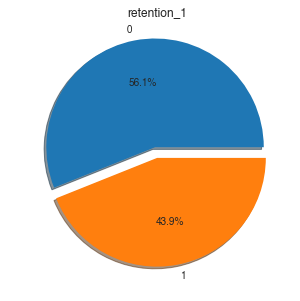

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ab_test['retention_1'].value_counts().plot.pie(explode = [0.1,0], autopct='%1.1f%%', shadow = True)
ax.set_title('retention_1')
ax.set_ylabel(' ')
plt.show()

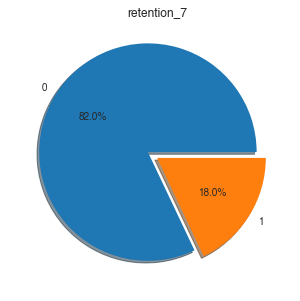

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
ab_test['retention_7'].value_counts().plot.pie(explode = [0.1,0], autopct='%1.1f%%', shadow = True)
ax.set_title('retention_7')
ax.set_ylabel(' ')
plt.show()

In [12]:
conversion_rates = ab_test.groupby('version')['retention_1']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['retention_1_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,retention_1_rate,std_deviation,std_error
version,,,
gate_30,0.445,0.497,0.007
gate_40,0.433,0.496,0.007


## Testing the hypothesis

In [13]:

gate_30_results = ab_test[ab_test['version'] == 'gate_30']['retention_1']
gate_40_results = ab_test[ab_test['version'] == 'gate_40']['retention_1']
n_30 = gate_30_results.count()
n_40 = gate_40_results.count()
successes = [gate_30_results.sum(), gate_40_results.sum()]
nobs = [n_30, n_40]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_30, lower_40), (upper_30, upper_40) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Rejection Region: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Confident Interval 95% for Gate_30 version: [{lower_30:.3f}, {upper_30:.3f}]')
print(f'Confident Interval 95% for Gate_40 version: [{lower_40:.3f}, {upper_40:.3f}]')

Rejection Region: 1.16
p-value: 0.246
Confident Interval 95% for Gate_30 version: [0.431, 0.460]
Confident Interval 95% for Gate_40 version: [0.419, 0.448]


We fail to reject H0 since p-value is not in rejection region